In [1]:
import pandas as pd 
import nltk
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
raw_train = pd.read_csv('train.csv') #Loading data
raw_test = pd.read_csv('test.csv')

In [3]:
raw_train.tail()

,Title,Class
2995,wagner pot liners2-1/2 gallon 0295272,paint
2996,nelson paint n201 marking tool replacement ada...,paint
2997,graco h43850 high-pressure spray hose 4500 psi,paint
2998,legend plate eaton ht8sp68,lighting
2999,compass ccrrc exit sign with emergency lights ...,lighting


In [4]:
print(raw_train.describe())

                                                   Title     Class
count                                               3000      3000
unique                                              3000         2
top     48" replacement lens acuity lithonia dlibz14 acl  lighting
freq                                                   1      1835


In [5]:
#print(raw_test.describe())

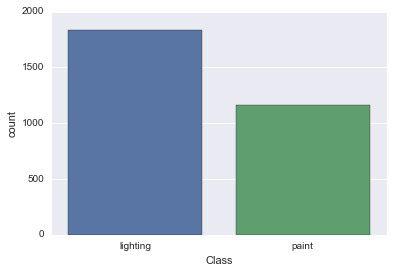

In [6]:
sns.countplot(raw_train['Class'], ) # Check if the data set is blanced

In [7]:
raw_train['Class'].value_counts()

lighting    1835
paint       1165
Name: Class, dtype: int64

### Feature extraction 

In [8]:
from nltk import wordpunct_tokenize
from nltk import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

In [9]:
raw_train['tokenized_title'] = raw_train.apply(lambda row: wordpunct_tokenize(row['Title']), axis=1)
#raw_train['tokenized_title'] = raw_train.apply(lambda row: nltk.wordpunct_tokenize(row['tokenized_title']), axis=1)

cc = []
for r,c in raw_train.iterrows():
    cc.append(''.join(c[2]))

raw_train['tokenized_title'] = cc   

In [10]:
raw_train.tail()

,Title,Class,tokenized_title
2995,wagner pot liners2-1/2 gallon 0295272,paint,wagnerpotliners2-1/2gallon0295272
2996,nelson paint n201 marking tool replacement ada...,paint,nelsonpaintn201markingtoolreplacementadapter
2997,graco h43850 high-pressure spray hose 4500 psi,paint,gracoh43850high-pressuresprayhose4500psi
2998,legend plate eaton ht8sp68,lighting,legendplateeatonht8sp68
2999,compass ccrrc exit sign with emergency lights ...,lighting,compassccrrcexitsignwithemergencylights3.56w


In [11]:
raw_train['num'] = raw_train['tokenized_title'].str.extract('(\d+)')

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  if __name__ == '__main__':


In [12]:
raw_train['tokenized_title'] = raw_train['tokenized_title'].str.replace('\d+', '') # remove numeric values from the title

##### Split data (train.csv) into train and test sets

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(raw_train[['tokenized_title','num']], raw_train['Class'], test_size=0.33, random_state=42)

In [14]:
X_train.head(2)

,tokenized_title,num
2761,rust-oleumengineenamelhihtfltalumozspray,248904
123,milwaukee--replacementbulbf/--pk,49


In [15]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [16]:
vzr = TfidfVectorizer(stop_words='english')

In [17]:
X_tfidf = vzr.fit_transform(X_train['tokenized_title']) # Use TF-IDF model to get feature vectors

In [18]:
X_tfidf.get_shape

<bound method spmatrix.get_shape of <2010x2180 sparse matrix of type '<class 'numpy.float64'>'
	with 3238 stored elements in Compressed Sparse Row format>>

In [19]:
#vzr.get_feature_names()

In [20]:
X_tfidf_test = vzr.transform(X_test['tokenized_title'])

In [21]:
X_tfidf_test.get_shape

<bound method spmatrix.get_shape of <990x2180 sparse matrix of type '<class 'numpy.float64'>'
	with 710 stored elements in Compressed Sparse Row format>>

In [22]:
t1 = pd.DataFrame(X_tfidf.toarray())

In [23]:
t1['num'] = X_train['num']

In [24]:
t2 = pd.DataFrame(X_tfidf_test.toarray())
t2['num'] = X_test['num']
#t2

In [27]:
t1.fillna(0, inplace=True)
t2.fillna(0, inplace=True)
#t2

In [28]:
from sklearn import preprocessing

In [32]:
x = t1.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df1 = pd.DataFrame(x_scaled)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


In [34]:
x = t2.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df2 = pd.DataFrame(x_scaled)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


In [36]:
#df2

In [37]:
from sklearn import preprocessing

In [38]:
le = preprocessing.LabelEncoder() 

In [39]:
Y1 = le.fit_transform(y_train) # Transform label value into numerics
Y2 = le.fit_transform(y_test)

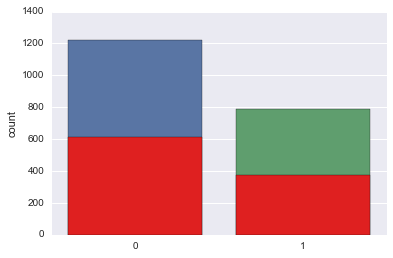

In [40]:
sns.countplot(Y1, )
sns.countplot(Y2, color='r') #

## Model Selection and Training

#### Here we train few classifiers using the defalt values of  their hyperparameters. Then we evaluate those models using the ROC curve (based on the 3-fold cross validation results)to select the most suitable model. Note here the hyperparamters are not tuned, due to limited time.

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, log_loss, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [46]:
classifiers = [
    KNeighborsClassifier(3),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    MultinomialNB()
]


In [47]:
# Function to plot ROC cure

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

calculating ROC for KNeighborsClassifier...
calculating ROC for DecisionTreeClassifier...
calculating ROC for RandomForestClassifier...
calculating ROC for AdaBoostClassifier...
calculating ROC for MultinomialNB...


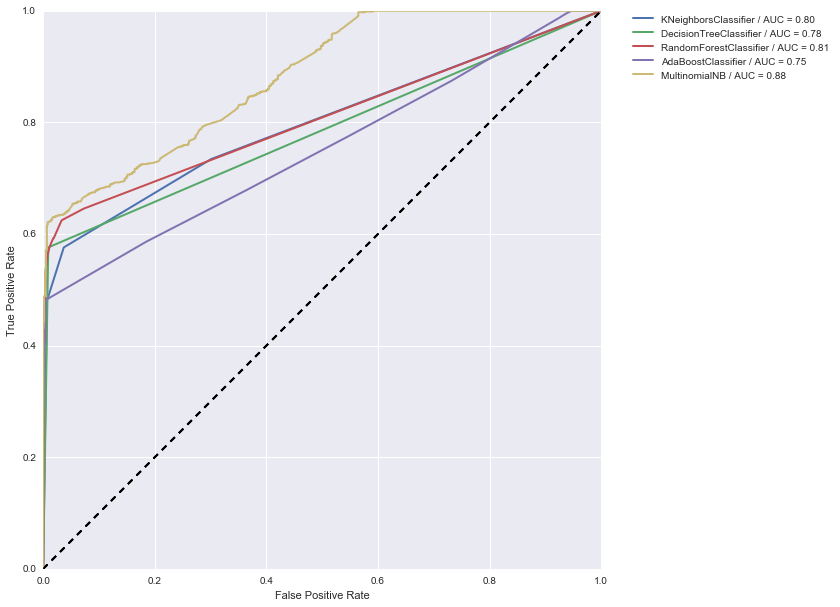

In [50]:
plt.figure(figsize=(10,10))

for clf in classifiers:
    #clf.fit(X_train, y_train)
    #clf.predict(X_test)
    name = clf.__class__.__name__
    print("calculating ROC for {}...".format(name))
    
    # Exception for the models that don't have a "decision_function()" method. For those moels "predict_proba"is being 
    # used and the scores are calculated using the class probability.
    
    try:
        y_scores = cross_val_predict(clf, df1, Y1, cv=5, method="decision_function")
        fpr, tpr, thresholds = roc_curve(Y1, y_scores)
    except AttributeError:
        y_probs = cross_val_predict(clf, df1, Y1, cv=5, method="predict_proba") 
        y_scores = y_probs[:, 1]
        fpr, tpr, thresholds = roc_curve(Y1, y_scores)
        
    auc_score = auc(fpr, tpr) # Area under the curve estimate
    
    plot_roc_curve(fpr, tpr, "{} / AUC = {:.2f}".format(name,auc_score))
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

calculating ROC for KNeighborsClassifier...
calculating ROC for DecisionTreeClassifier...
calculating ROC for RandomForestClassifier...
calculating ROC for AdaBoostClassifier...
calculating ROC for MultinomialNB...


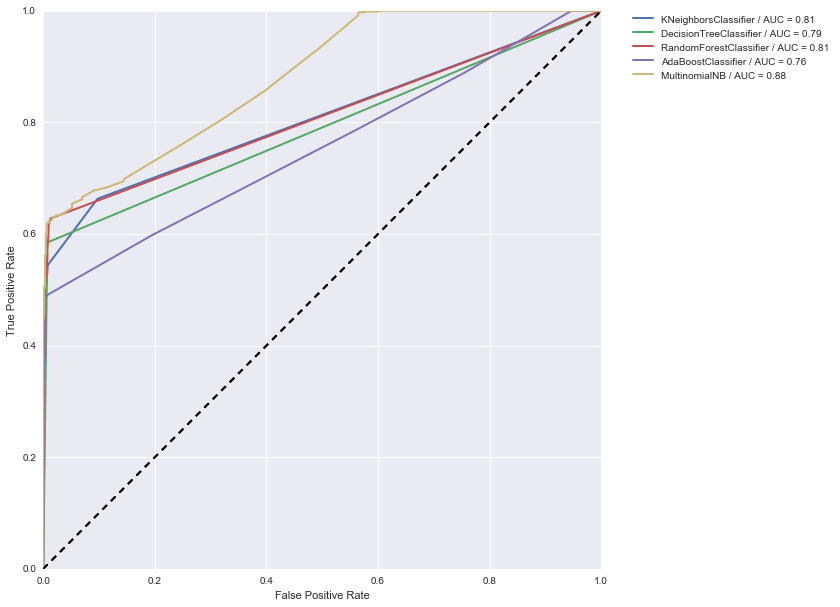

In [49]:
plt.figure(figsize=(10,10))

for clf in classifiers:
    #clf.fit(X_train, y_train)
    #clf.predict(X_test)
    name = clf.__class__.__name__
    print("calculating ROC for {}...".format(name))
    
    # Exception for the models that don't have a "decision_function()" method. For those moels "predict_proba"is being 
    # used and the scores are calculated using the class probability.
    
    try:
        y_scores = cross_val_predict(clf, X_tfidf, Y1, cv=5, method="decision_function")
        fpr, tpr, thresholds = roc_curve(Y1, y_scores)
    except AttributeError:
        y_probs = cross_val_predict(clf, X_tfidf, Y1, cv=5, method="predict_proba") 
        y_scores = y_probs[:, 1]
        fpr, tpr, thresholds = roc_curve(Y1, y_scores)
        
    auc_score = auc(fpr, tpr) # Area under the curve estimate
    
    plot_roc_curve(fpr, tpr, "{} / AUC = {:.2f}".format(name,auc_score))
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### Based on the ROC curve, it is clear that SVC and MutinomialNB perform better than other classifiers.  Therefore we continue to tune the SVC model to get the parameters using scikit GridsearchCV.

In [29]:
param_grid = [{'kernel': ['rbf','linear', 'poly', 'sigmoid'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

In [30]:
svc = SVC()

In [31]:
grid_search = GridSearchCV(svc, param_grid=param_grid, cv=3, )

In [32]:
grid_search.fit(X_tfidf, Y1)

GridSearchCV(cv=3, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'C': [1, 10, 100, 1000], 'kernel': ['rbf', 'linear', 'poly', 'sigmoid'], 'gamma': [0.001, 0.0001]}, {'C': [1, 10, 100, 1000], 'kernel': ['linear']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [33]:
grid_search.best_params_ # bese hyperparameters 

{'C': 10, 'gamma': 0.001, 'kernel': 'linear'}

In [34]:
grid_search.best_score_

0.83432835820895523

0.890256277236


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


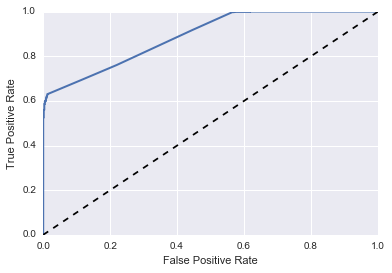

In [35]:
#Re-evalute the model using funed parameters. Slight increse in the AUC can be seen.

y_scores = cross_val_predict(grid_search.best_estimator_, X_tfidf, Y1, cv=5, method="decision_function")
fpr, tpr, thresholds = roc_curve(Y1, y_scores)
plot_roc_curve(fpr, tpr)
print(auc(fpr, tpr))
plt.legend()
plt.show()

### Evaluate the model on the test set 

In [36]:
y_true, y_pred = y_test, grid_search.predict(X_tfidf_test)

In [37]:
from sklearn.metrics import classification_report

In [38]:
print(classification_report(Y2, y_pred))

             precision    recall  f1-score   support

          0       0.82      0.99      0.90       615
          1       0.98      0.65      0.78       375

avg / total       0.88      0.86      0.85       990



#### The performance of the classifier can certianly be improved by doing further feature engineering.

In [39]:
accuracy_score(Y2, y_pred) # Accuracy on the test set

0.86161616161616161

In [40]:
sum(Y2==1), sum(y_pred==1), 246/375

(375, 246, 0.656)

# Prediction on the new data ( from test.csv)

In [41]:
raw_test['tokenized_title'] = raw_test.apply(lambda row: nltk.wordpunct_tokenize(row['Title']), axis=1)

In [42]:
cc=[]
for r,c in raw_test.iterrows():
    cc.append(''.join(c[2]))
raw_test['tokenized_title'] = cc

In [43]:
raw_test['tokenized_title'] = raw_test['tokenized_title'].str.replace('\d+', '')

In [44]:
raw_test.tail()

,Title,Class,tokenized_title
3892,"6-5/8"" led can light trim flat black cree lt6b...",NaN,"-/""ledcanlighttrimflatblackcreeltbb-dr"
3893,1xrh7 paint brush 4in. 11-3/4in.,NaN,xrhpaintbrushin.-/in.
3894,sprayon s00605000 fast cure insulating varnish,NaN,sprayonsfastcureinsulatingvarnish
3895,red devil equipment company 507000 lid sealer ...,NaN,reddevilequipmentcompanylidsealergal.
3896,eaton ht8gdcl1 illum push button operator 30mm...,NaN,eatonhtgdclillumpushbuttonoperatormmclear


In [45]:
test_data = vzr.transform(raw_test['tokenized_title'])

In [46]:
test_pred = grid_search.best_estimator_.predict(test_data)

In [47]:
sum(test_pred == 1)

996

In [48]:
prediction = le.inverse_transform(test_pred)

In [49]:
raw_test['Class'] = prediction

In [50]:
raw_test.head(2)

,Title,Class,tokenized_title
0,philips advance izt132sc dimming ballastelectr...,lighting,philipsadvanceiztscdimmingballastelectronic/vlamp
1,krylon k06903400 rust preventative spray paint...,lighting,krylonkrustpreventativespraypaintflatwhite


In [51]:
raw_test[['Title', 'Class']].to_csv('/Users/gemunu/Desktop/test.csv', index=None)